In [1]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())

import mmdet
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
import mmocr
import matplotlib.pyplot as plt
import cv2

from imutils.object_detection import non_max_suppression
from skewness import *

from mmocr.apis import MMOCRInferencer

import cv2
from craft_text_detector import Craft
import matplotlib.pyplot as plt
import os
import pytesseract

2.0.1 True


In [2]:
ocr = MMOCRInferencer(det='TextSnake')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500_20221101_134814-a216e5b2.pth
08/17 15:41:56 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.


c:\Users\Ghost\anaconda3\envs\galli_maps\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [102]:
def order_contour_clockwise(contour):
    # Calculate the centroid of the contour
    M = cv2.moments(contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    # Calculate the angle of each point with respect to the centroid
    def angle_key(point):
        x, y = point
        # print(np.degrees(np.arctan2(y - cy, x - cx)))
        return np.arctan2(y - cy, x - cx)

    
    # Sort the contour points based on the angle with respect to centroid
    sorted_contour = sorted(contour, key=angle_key, reverse = False)  # Clockwise
    
    return np.array(sorted_contour)

In [103]:
def order_contour_anti_clockwise(contour):
    # Calculate the centroid of the contour
    M = cv2.moments(contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    # Calculate the angle of each point with respect to the centroid
    def angle_key(point):
        x, y = point
        # print(np.degrees(np.arctan2(y - cy, x - cx)))
        return np.arctan2(y - cy, x - cx)

    
    # Sort the contour points based on the angle with respect to centroid
    sorted_contour = sorted(contour, key=angle_key)  # Clockwise
    
    return np.array(sorted_contour)

In [4]:
# def orientation(contour):
#     # Extract the first and last points of the contour
#     first_point = contour[0]
#     last_point = contour[1]

#     # Calculate the cross product between the vector and the positive x-axis
#     cross_product = -np.cross(last_point, first_point)
#     print(f'Cross Product : {cross_product}')
#     if cross_product > 0:
#         # The contour makes a counterclockwise angle with the x-axis.
#         return 0
#     elif cross_product < 0:
#         # The contour makes a clockwise angle with the x-axis.
#         return 1
#     else:
#         # The contour is aligned with the x-axis.
#         return None

In [104]:
def orientation(contour):
    new_contour = order_contour_clockwise(contour)
    # print(new_contour)
    if np.array_equal(new_contour, contour):
        return 0
    else:
        return 1

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

[[267 140]
 [284 125]
 [559 443]
 [542 457]]
clockwise
angle: 49.058103802731544


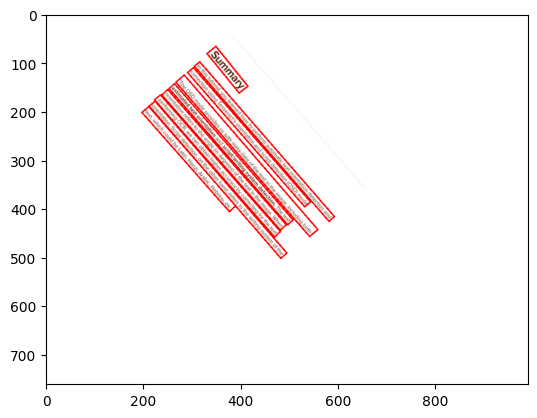

In [125]:
img = cv2.imread('images/tt.png')
image = img.copy()
det = ocr(img)
imgc = img.copy()
boxes = det['predictions'][0]['det_polygons']
angled_boxes = []
for box in boxes:
    if len(box) >= 3:  # Ensure at least 3 points for a polygon
        # Convert box points to numpy array for easier manipulation
        box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

        # Calculate the minimum bounding rectangle
        rotated_rect = cv2.minAreaRect(box_points)
        box_vertices = cv2.boxPoints(rotated_rect)
        box_vertices = np.int0(box_vertices)
        angled_boxes.append(box_vertices)
        # Draw the rotated rectangle
        cv2.drawContours(img, [box_vertices], 0, (255, 0, 0), 2)

plt.imshow(img)

largest_contour = max(angled_boxes, key=cv2.contourArea)
print(largest_contour)
counter_clockwise = orientation(largest_contour)

if counter_clockwise:
    # Calculate the angle for counterclockwise orientation
    largest_contour = order_contour_anti_clockwise(largest_contour)
    print(largest_contour)
    print('counter_clockwise')
    orientation(largest_contour)
    x1, y1 = largest_contour[3]
    x2, y2 = largest_contour[0]
    if x2 - x1 != 0:
        slope = (y2 - y1) / (x2 - x1)
        angle_radians = np.arctan(slope)
        angle = np.degrees(angle_radians)
    else:
        angle = 90
else:
    print('clockwise')
    # Calculate the angle for clockwise orientation
    largest_contour = order_contour_clockwise(largest_contour)
    x1, y1 = largest_contour[3]
    x2, y2 = largest_contour[0]
    if x2 - x1 != 0:
        slope = (y2 - y1) / (x2 - x1)
        angle_radians = np.arctan(slope)
        angle = np.degrees(angle_radians)
    else:
        angle = 90

print(f'angle: {angle}')
# print(f'angle_degrees : {angle_degrees}')

height, width = img.shape[:2]
center = (width // 2, height // 2)
imgc = cv2.drawContours(imgc,[largest_contour],0,(0,255,0),2)
if angle != 90:
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
else:
    rotated_image = image.copy()

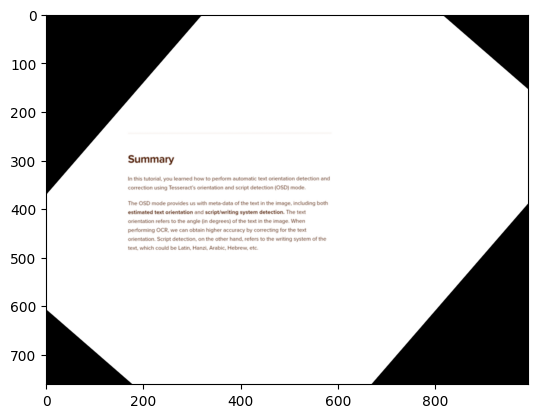

In [126]:
plt.imshow(rotated_image)
plt.show()

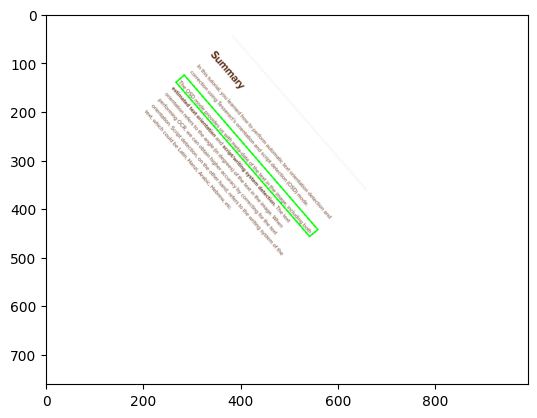

In [127]:
plt.imshow(imgc)

In [128]:
largest_contour

array([[267, 140],
       [284, 125],
       [559, 443],
       [542, 457]], dtype=int64)